<a href="https://colab.research.google.com/github/ZahraAlharz/Oxford-AI-Summer-School/blob/main/Deep_Q_Learning_H_M_Oxford.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook has been inspired from [REINFORCEMENT LEARNING (DQN) TUTORIAL](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) and [reinforcement_q_learning](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/reinforcement_q_learning.ipynb#scrollTo=ChfTgUJGcvEA) by Paszke & Towers.

# Deep Q-Learning

In this notebook, we will implement Deep Q-Learning Reinforcement learning algorithm for Cart Pole Environment.

## Cartpole

As the image below shows, the goal of the agent is to balance a verticle rod on the top of the car. This position is unstable and that is the main reason for the difficulty.

![Cartpole](https://gymnasium.farama.org/_images/cart_pole.gif)

The problem is solved if the average of the agent's scores is greater than 195 gathered in 100 episodes.
The agent receives reward 1 in each timestep until the psoition of the rod is correct (not inclined too far away from the vertical position).

The episode ends if any one of the following occurs:
- Pole Angle is greater than ±12°
- Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
- Episode length is greater than 500 (200 for v0)

The state is low dimensional and cosists of:
* position
* velocity
* angle
* angular velocity

You can read more the cartpole environment [here](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

## Deep Q-Learning

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

But this is not scalable. Must compute $Q(s,a)$ for every state-action pair. If state is e.g. current game state pixels, computationally infeasible to compute for entire state space! But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the `Huber
loss <https://en.wikipedia.org/wiki/Huber_loss>`__. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}



![alt text](dqn_target.png)

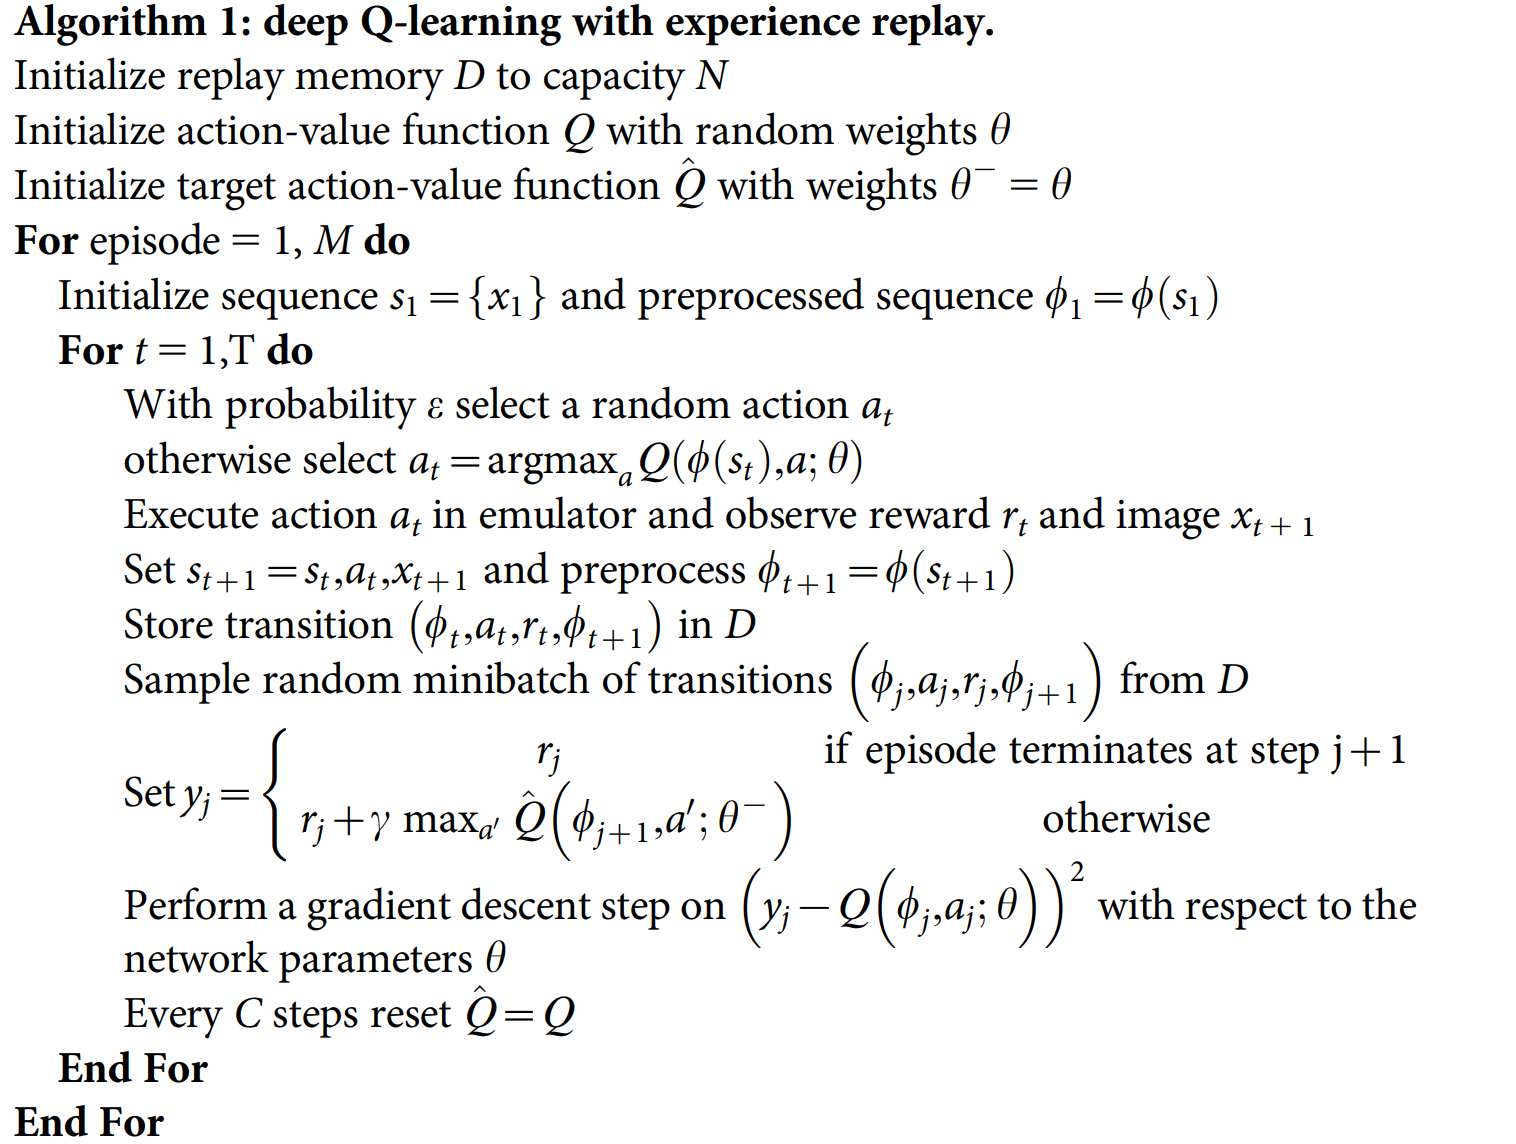

In [ ]:
!pip install -q swig
!pip install -q gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 48.0 MB/s eta 0:00:00


In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Create the environment
env = gym.make("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Experience Replay

Learning from batches of consecutive samples is problematic as the sample are correlated and it can create a bad feedback loop if one action is dominated in the samples.

We can address these problems using an experience replay memory. It maintains a record for all the transitions experienced. The agent is then trained by sampling random minibatches from the replay memory.

In [ ]:
# Named tuple representing a single transition in our environment
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

# Cyclic buffer of bounded size that holds and samples the transitions observed recently
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Q-Network

In [ ]:
# A neural network approximater for Q-Value.
# It takes the state as input and predicts the Q-value for all actions at that state
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

### Exploration vs Exploitation

Notice that Q-learning only learns about the states and actions it visits. What if an optimal state remains unvisited due to not being explored. The agent should sometimes pick suboptimal actions in order to visit new states and actions. <br>

A simple strategy is to use an $\epsilon$-greedy policy. According to this policy, the agent takes a random action with epsilon probability. The value of epsilon is high at the start of training and low towards the end. So, the agent explores more at the start and then exploit the learned policy more at the end.

### Hyperparameters

In [ ]:
# Here, we will specify the hyperparameters

total_episodes = 1000         # Total training episodes
max_steps = 200              # Max steps per episode
learning_rate = 1e-3         # Learning rate|
gamma = 0.99                 # Discounting rate
batch_size = 128             # Training Batch size
target_update = 5            # Target network update frequency
train_frquency = 1           # Train Q network every train_frquency episodes
train_epochs = 2             # Training epochs during each training cycle

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 0.003            # Exponential decay rate for exploration prob

### Training

In [ ]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print('state size:', state_size)
print('action size:', action_size)

observation space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
action space: Discrete(4)
state size: 8
action size: 4


In [ ]:
# Intialize both Q-networks
policy_net = DQN(state_size, action_size).to(device)
target_net = DQN(state_size, action_size).to(device)

# update target network
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# set up the optimizer
optimizer = optim.RMSprop(policy_net.parameters(), lr=learning_rate)

# Initialize the replay buffer
memory = ReplayMemory(10000)

In [ ]:
# get action for current state according to the greedy policy
def get_action(state):
  ## First we randomize a number
  exp_exp_tradeoff = random.uniform(0, 1)
  ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
  if exp_exp_tradeoff > epsilon:
    with torch.no_grad():
      action = policy_net(state).max(1)[1].view(1, 1)

  # Else doing a random choice --> exploration
  else:
    action = env.action_space.sample()
    action = torch.tensor([action], device=device).view(1, 1)
  return action

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

# Assuming you have already defined your environment (env) and other necessary imports

class Policy(nn.Module):
    def __init__(self, state_size, action_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    probs = policy(state)
#action probabilities function where it maps each action with a probability all sum to 1
#Categorical class combines probability distrbutiion to help with sampling (giving highest value) so at end will give me one action
    m = torch.distributions.Categorical(probs)
    action = m.sample()
    return action.item(), m.log_prob(action)

def update_policy(rewards, log_probs):
    discounted_rewards = []
    R = 0
    for r in rewards[::-1]:
        R = r + gamma * R
        discounted_rewards.insert(0, R)
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + eps)

    policy_loss = []
    for log_prob, R in zip(log_probs, discounted_rewards):
        policy_loss.append(-log_prob * R)
    policy_loss = torch.cat(policy_loss).sum()

    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

# Hyperparameters
gamma = 0.99
lr = 0.001
eps = np.finfo(np.float32).eps.item()
total_episodes = 2000
max_steps = 1000    #between 500 and 1000

# Initialize policy network
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
policy = Policy(state_size, action_size).to(device)
optimizer = optim.Adam(policy.parameters(), lr=lr)

# List of rewards
rewards = []

for episode in range(1, total_episodes+1):
    state = env.reset()
    episode_rewards = []
    episode_log_probs = []
    total_reward = 0

    for t in range(max_steps):
        action, log_prob = select_action(state)
        next_state, reward, done, _ = env.step(action)

        episode_rewards.append(reward)
        episode_log_probs.append(log_prob)
        total_reward += reward

        state = next_state

        if done:
            break

    update_policy(episode_rewards, episode_log_probs)
    rewards.append(total_reward)

    print(f"Episode {episode}: Reward = {total_reward}")

# Print average reward of last 100 episodes
print(f"Average reward of last 100 episodes: {np.mean(rewards[-100:])}")

Episode 1: Reward = -183.25193368045973
Episode 2: Reward = -206.73359690029855
Episode 3: Reward = -140.7863092060438
Episode 4: Reward = -270.7065016395701
Episode 5: Reward = -112.4527397741351
Episode 6: Reward = -222.30602493463908
Episode 7: Reward = -218.49891100359594
Episode 8: Reward = -403.65378682214214
Episode 9: Reward = -83.15178636956875
Episode 10: Reward = -108.88234757381197
Episode 11: Reward = -148.81928048509718
Episode 12: Reward = -141.6431264918182
Episode 13: Reward = -82.75094930499264
Episode 14: Reward = -80.05925328731209
Episode 15: Reward = -282.05898526209546
Episode 16: Reward = -333.02493283704985
Episode 17: Reward = -118.84946864009652
Episode 18: Reward = -261.62334245676016
Episode 19: Reward = -109.18963458809789
Episode 20: Reward = -93.75306161511968
Episode 21: Reward = -115.53768533260235
Episode 22: Reward = -381.4721637969898
Episode 23: Reward = -224.09252217076352
Episode 24: Reward = -100.92662175422404
Episode 25: Reward = -112.39801257

Text(0, 0.5, 'Reward')

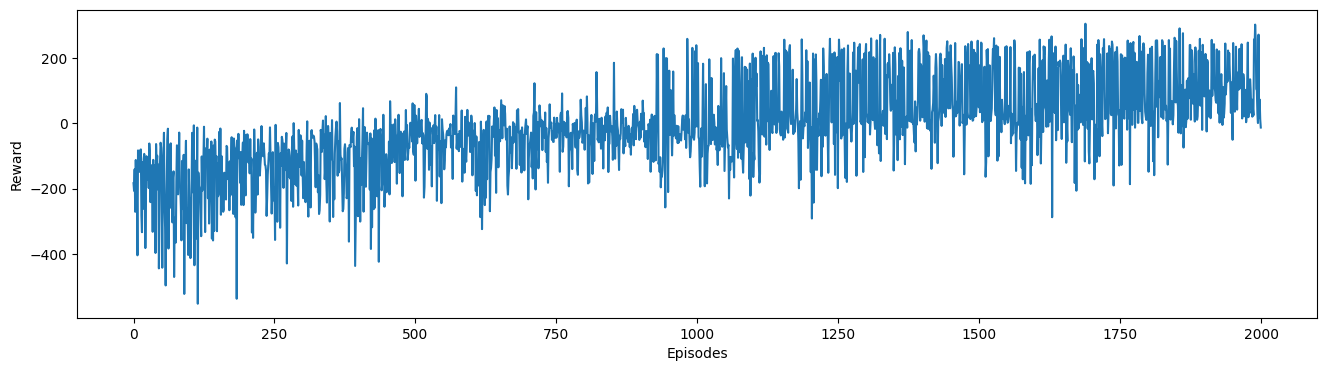

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(rewards)
plt.xlabel("Episodes")
plt.ylabel("Reward")

### Visualization

In [ ]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [ ]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    state = torch.tensor([state], device=device)
    done = False
    for t in range(max_steps):
        vid.capture_frame()
        action = get_action(state)
        next_state, reward, done, info = env.step(action.item())
        next_state = torch.tensor([next_state], device=device)
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [ ]:
show_video_of_model("CartPole-v1")

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [ ]:
show_video("CartPole-v1")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
